# P4: MDPs and Reinforcement Learning

**DUE: Saturday April 2nd, 2022**

**Instructions for submission are the same as they have been.**

You may recognize some of the starter code as being from L02! I'm giving you a random adjacency graph for you to play around with. The agent's goal is to maximize it's reward (which happens when it reaches the node in the "middle" of the graph). There's a catch: actions are somewhat stochastic. Every time the agent executes an action, there is a random chance it will end up in any of the states reachable from its current state. I am providing you with a couple *policies*: functions that take in a state and return the action the agent should take.

This is the environment that you will be using for most of your assignment, so you might want to read through it to make sure you understand what's going on. A few things to note:

$P(s' | s, a) = $ `world.get_transition_probs(state, action)`

$R(s) = $ `world.rewards`

Also, if you have a value function $V(s)$, this means that $\sum_{s' \in S} P(s' | s, a) V^*(s')$ = `np.dot(world.get_transition_probs(state, action), values)`. I'm sure this will help you in your answers below!

Note that in your implementations, sometimes you want to get the argmax or argmin of some list: you want to find the action that maximizes or minimizes some value. Here's an example: if you want to find the action that minimizes the value of `something`, you can use the following code:
```python
actions = env.get_actions_for_state(state)
action_index = np.argmin(something[actions])
minimizing_action = actions[action_index]
```
Your list of actions acts as a list of indices for the `something` vector, so `something[actions]` gives you the values of `something` for those actions. `np.argmin` gives you the index that maximizes `something[actions]`. With that index, you can plug it back into the list of actions to get the action that would have minimized `something`. I expect you will find this useful for a few aspects of your implementation.

In [27]:
# Starter Code: Graph definition and plotting (modified from L02B)

import matplotlib.pyplot as plt
import numpy as np
import random


def get_random_adjacency(band_size, num_nodes, edge_rate=1.0, seed=695):
    random.seed(seed)
    mat = np.zeros((num_nodes, num_nodes))
    for ii in range(num_nodes):
        mat[ii, ii] = 1.0
        for jj in range(ii + 1, min(ii+band_size, num_nodes)):
            val = 1.0 * (random.random() < edge_rate)
            mat[ii, jj] = val
            mat[jj, ii] = val
    return mat


def plot_adjacency_mat(mat):
    plt.figure(dpi=150)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(mat, interpolation='none')


class AdjacencyWorld(object):
    def __init__(self, num_nodes, band_size=10, edge_rate=0.5, random_move_chance=0.5, seed=695):
        self.mat = get_random_adjacency(band_size=band_size, num_nodes=num_nodes, edge_rate=edge_rate, seed=seed)
        self.states = list(range(num_nodes))
        self.rewards = -1 * np.ones((num_nodes))
        self.goal = num_nodes//2
        self.rewards[self.goal] = 10
        self.random_move_chance = random_move_chance
    
    def get_actions_for_state(self, state): 
        """Get the available 'moves' from the current state.
        return: list of indices connected to 'state'."""
        return np.where(self.mat[state])[0].tolist()
    
    def get_transition_probs(self, state, action):
        """Get a list of the transition probabilities for a state and action."""
        actions = self.get_actions_for_state(state)
        num_actions = len(actions)
        prob_vec = np.zeros_like(self.rewards)
        for rand_action in actions:
            prob_vec[rand_action] = self.random_move_chance / num_actions
        
        prob_vec[action] += (1 - self.random_move_chance)
        return prob_vec
    
    def get_random_state(self):
        return random.choice(self.states)

    def execute_action(self, state, action):
        assert action in self.get_actions_for_state(state)
        probs = self.get_transition_probs(state, action)
        new_state = np.random.choice(self.states, p=probs)
        return self.rewards[new_state], new_state

## P4.1 Evaluating Policies

In class, we discussed two different ways of evaluating a policy: First-visit MC prediction and a linear-algebra-based procedure.

### P4.1.1 First-Visit MC Policy Evaluation [4 points]

**TASK** Complete the `evaluate_policy_first_visit_mc` function below using the First Visit MC prediction algorithm we discussed in class. 

I have provided you with significant starter code for this purpose. At each step during the MC evaluation, I record the current state and action, the reward returned after executing the action, and the states that have been visited so far (needed to evaluate whether it was a *first visit*). In the second loop, which you should complete, we iterate through that list backwards, as it is done in the algorithm pseudocode from class. It might also help you to know that I have stored the returns as a python dictionary; when you want to add a new 'return', you should use something that looks like `returns[state] += [something]`. Once you have populated the returns, computing the values can be done by looping through `state, returns in returns.items()`; feel free to use a value of 0 if `len(returns) == 0`.

When completed, if implemented correctly, for a "random move chance" of 0.2, the average value of policy 1 should be roughly -48 and the average return value of policy 2 should be roughly 20 (plus or minus three or so).

**CODE** Include your completed implementation in your writeup.

**RESULTS** Include the computed output average values for each of the provided policies.

**PLOTS** Include the generated plot of the computed value for each policy (for a random move chance of 0.5) in your writeup.

**QUESTION** (1-2 sentences) How do the costs of each policy compare as the random move chance becomes 1.0? Why?

In [48]:
# STARTER CODE: First Visit MC Policy Evaluation

def evaluate_policy_first_visit_mc(world, policy, num_iterations=1000, gamma=0.98, num_steps=200, seed=695):
    """Returns a list such that value[state] is the value of that state."""
    # Perform a bunch of rollouts
    random.seed(seed)
    np.random.seed(seed)
    returns = {s: [] for s in world.states}

    for _ in range(num_iterations):
        # Rollout
        state = world.get_random_state()
        steps = []
        states_so_far = set()
        for _ in range(num_steps):
            action = policy[state]
            reward, new_state = world.execute_action(state, action)
            steps.append((state, action, reward, states_so_far.copy()))
            states_so_far.add(new_state)
            state = new_state
        G = 0
        
        for s, a, r, states_so_far in reversed(steps):
            G = gamma * G + r
            if s not in states_so_far:
                returns[s]+=[G]
                
    values = []
    for state, returns in returns.items():
        if len(returns) == 0: 
            values.append(0)
        else:
            values.append(sum(returns)/len(returns))
    return values

== Policy 1 ==
 Chance:  0.0 | Average Value: -49.12060266971388
 Chance:  0.2 | Average Value: -48.89508342835458
 Chance:  0.5 | Average Value: -48.48344138693204
 Chance:  0.8 | Average Value: -47.71995137245433
 Chance:  1.0 | Average Value: -46.80535428375775
== Policy 2 ==
 Chance:  0.0 | Average Value: 15.232148341510536
 Chance:  0.2 | Average Value: 20.74578379235873
 Chance:  0.5 | Average Value: -12.220567532782493
 Chance:  0.8 | Average Value: -36.609129892592826
 Chance:  1.0 | Average Value: -46.80535428375775


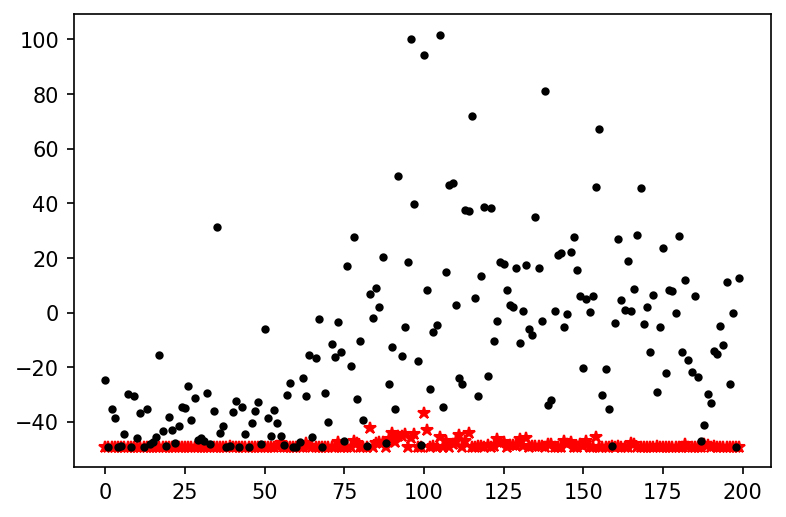

In [49]:
# Plotting and evaluation code
world = AdjacencyWorld(200, band_size=20, edge_rate=0.1, random_move_chance=0.0, seed=695)


# Policy 1
policy_1 = [random.choice(world.get_actions_for_state(state)) 
            for state in world.states]

# Policy 2
policy_2 = [0] * len(world.states)
for state in world.states:
    actions = np.array(world.get_actions_for_state(state))
    action_ind = np.argmin(np.abs(actions - world.goal))
    policy_2[state] = actions[action_ind]
    
def evaluate_policy_multiple(world, policy):
    for rmc in [0.0, 0.2, 0.5, 0.8, 1.0]:
        world.random_move_chance = rmc
        values = evaluate_policy_first_visit_mc(world, policy)
        print(f" Chance: {rmc:4.1f} | Average Value: {np.mean(values)}")


plt.figure(dpi=150)
world.random_move_chance = 0.5
plt.plot(evaluate_policy_first_visit_mc(world, policy_1), 'r*')
plt.plot(evaluate_policy_first_visit_mc(world, policy_2), 'k.')

print("== Policy 1 ==")
evaluate_policy_multiple(world, policy_1)

print("== Policy 2 ==")
evaluate_policy_multiple(world, policy_2)


None

### P4.1.2 Linear Algebra Solution [4 points]

As we discussed in class, there is a more direct (non-sampling-based) way to tackle this problem: linear algebra. While the strategy doesn't scale well to large problems, ours is small enough that it won't matter much. This method aims to solve the following linear system:

$$ V(s) = R_s + \gamma \sum_{s'} P_(s' | s, a)V(s') $$

In matrix, form we can write this as follows:

$$ V = R + \gamma P V $$

Rearranging, we find:

$$ (\mathbb{I} - \gamma P) V = R $$

where $\mathbb{I}$ is the identity matrix (implemented in numpy as `np.eye(N)`, where N is the side length). Numpy can be used to solve for a linear system like this. If $Ax = b$, then `x = np.linalg.solve()`. It is up to you to figure out how to build the $P$ matrix using `world.get_transition_probs(state, action)` (where `action = policy[state]` by definition of the policy).

Your results should be pretty close to the previous implementation, though the computation will no doubt be significantly faster.

**TASK** Complete the `evaluate_policy` function below.

**CODE** Include the completed `evaluate_policy` function in your writeup.

**RESULTS** Include the computed output average values for each of the provided policies.

**PLOTS** Include the generated plot of the computed value for each policy (for a random move chance of 0.5) in your writeup.

**QUESTION** (1-2 sentences) How do the costs of each policy compare as the random move chance becomes 1.0? Why?

In [32]:
def evaluate_policy(env, policy, gamma=0.98):
    """Returns a list of values[state]."""
    states = env.states
    rewards = env.rewards
    
    N = len(policy)
    i = np.eye(N)
    p = np.eye(N)
    for state in states:
        p[state] = env.get_transition_probs(state, policy[state])
    a = gamma * p
    A = i - a
    x = np.linalg.solve(A,rewards)
    return x

== Policy 1 ==
 Chance:  0.0 | Average Value: -49.944999999999936
 Chance:  0.2 | Average Value: -49.67471869687554
 Chance:  0.5 | Average Value: -49.23657274697364
 Chance:  0.8 | Average Value: -48.46321813637229
 Chance:  1.0 | Average Value: -47.55915548093535
== Policy 2 ==
 Chance:  0.0 | Average Value: 14.35308340966287
 Chance:  0.2 | Average Value: 22.61595156055575
 Chance:  0.5 | Average Value: -13.931551639369333
 Chance:  0.8 | Average Value: -37.611467812607856
 Chance:  1.0 | Average Value: -47.55915548093535


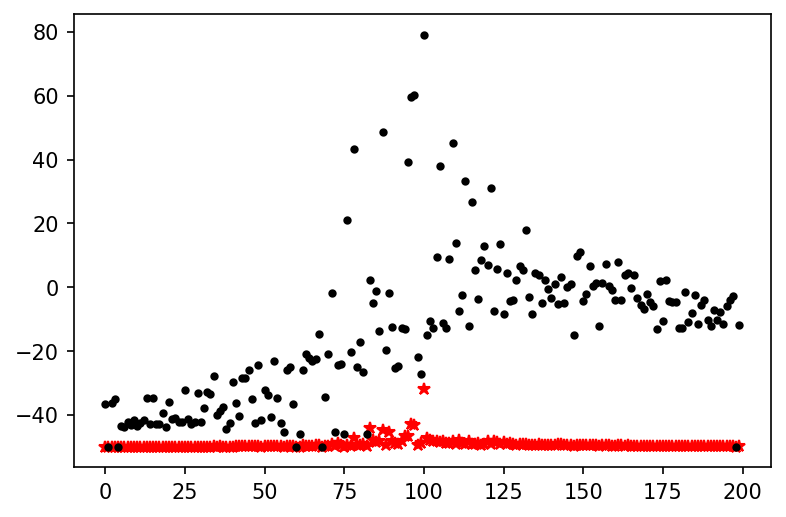

In [33]:
def evaluate_policy_multiple(world, policy):
    for rmc in [0.0, 0.2, 0.5, 0.8, 1.0]:
        world.random_move_chance = rmc
        values = evaluate_policy(world, policy)
        print(f" Chance: {rmc:4.1f} | Average Value: {np.mean(values)}")


plt.figure(dpi=150)
world.random_move_chance = 0.5
plt.plot(evaluate_policy(world, policy_1), 'r*')
plt.plot(evaluate_policy(world, policy_2), 'k.')

print("== Policy 1 ==")
evaluate_policy_multiple(world, policy_1)

print("== Policy 2 ==")
evaluate_policy_multiple(world, policy_2)

None

## P4.2 Value Iteration [8 points]

In class, we looked at *Value Iteration* as a technique to compute the *optimal policy*. Here, you will implement two functions relevant to this problem: value iteration itself, and a separate function that is used to determine the optimal policy from the computed values and the world model. First, you will implement value iteration.

**TASK** Implement the `value_iteration` function below using information from the in-class slides for how to iteratively update the value function. Key to this is that you are trying to find the action which will maximize the future expected reward. For this purpose, you will need both `world.get_actions_for_state(state)` and `world.get_transition_probs(state, action)`.

**CODE** Include your implementation of `compute_policy_from_values` in your writeup.

Next you will need to compute the policy from the values you computed above. For our scenario, to compute the policy from values, you should use the following formula.

$$ \pi^*(s) = \arg\max_a \sum_{s' \in S} P(s' | s, a) V^*(s') $$

**TASK** Implement the `compute_policy_from_values` function.

**CODE** Include your implementation of `compute_policy_from_values` in your writeup.

**RESULTS & PLOTS** Finally, run the code below and include the plots and results.

**QUESTION** (2-3 sentences) There are a few states for which the value is very low for all three values of random move chance. Why is this the case?

In [34]:
# Starter Code

def value_iteration(world, num_iterations, gamma=0.98):
    # values is a vector containing the value for each state.
    values = world.rewards.copy()
    # values_over_iterations is a vector of the values at each iteration (for visualization)
    values_over_iterations = [values.copy()]
    epsilon = .5
    
    for _ in range(num_iterations):
        # Perform one step of value iteration
        for state in world.states:
            temp = []
            for action in world.get_actions_for_state(state):
                temp.append(np.dot(world.get_transition_probs(state, action), values))
            values[state] = world.rewards[state] + max(temp) * gamma
        if max(abs(values_over_iterations[-1]-values)) < epsilon:
            break
        # Store the values in the 'all_values' list (for visualization)
        values_over_iterations.append(values.copy())
        
    # Return the all_values list; all_values[-1] are the final values.
    return values_over_iterations


def compute_policy_from_values(world, values):
    """policy is a mapping from states -> actions. 
    Here, it's just a vector: action = policy[state]"""
    # Initialize the policy vector
    policy = np.zeros_like(world.states)

    # Compute the policy for every state
    for state in world.states:
        max_action = -999
        temp_val = -999
        for action in world.get_actions_for_state(state):
            if temp_val < np.dot(world.get_transition_probs(state, action), values):
                temp_val = np.dot(world.get_transition_probs(state, action), values)
                max_action = action
        policy[state] = max_action

    return policy

== Policy 1 ==
 Chance:  0.0 | Average Value: -49.944999999999936
 Chance:  0.2 | Average Value: -49.67471869687554
 Chance:  0.5 | Average Value: -49.23657274697364
 Chance:  0.8 | Average Value: -48.46321813637229
 Chance:  1.0 | Average Value: -47.55915548093535
== Policy 2 ==
 Chance:  0.0 | Average Value: 14.35308340966287
 Chance:  0.2 | Average Value: 22.61595156055575
 Chance:  0.5 | Average Value: -13.931551639369333
 Chance:  0.8 | Average Value: -37.611467812607856
 Chance:  1.0 | Average Value: -47.55915548093535
== Policy Value Iteration (rmc = 0.2) ==
 Chance:  0.0 | Average Value: 423.8196062104148
 Chance:  0.2 | Average Value: 330.7494726654674
 Chance:  0.5 | Average Value: 155.7468615368327
 Chance:  0.8 | Average Value: -8.875513345905023
 Chance:  1.0 | Average Value: -47.55915548093535


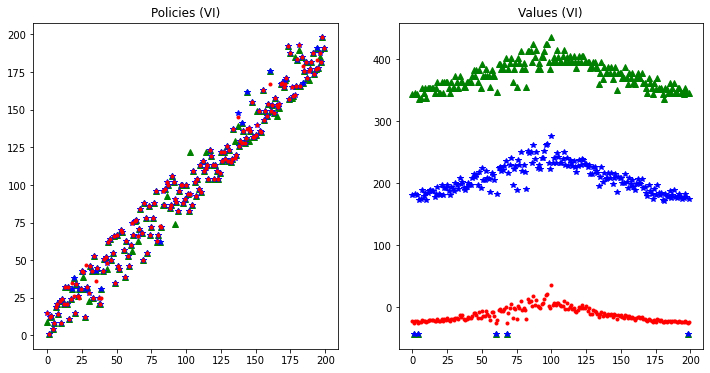

<Figure size 576x576 with 0 Axes>

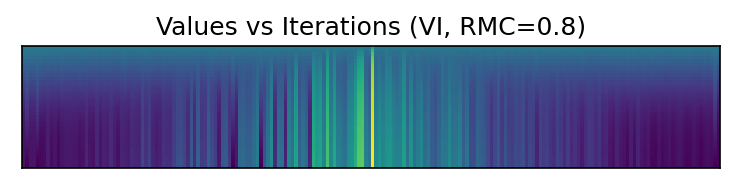

In [35]:
# Results & Plotting Code

# Plot the adjacency matrix we'll be using
world = AdjacencyWorld(200, band_size=20, edge_rate=0.1, random_move_chance=0.0, seed=695)

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plt.title("Policies (VI)")
ax2 = plt.subplot(122)
plt.title("Values (VI)")

# No randomness in move selection
world.random_move_chance=0.0
all_values = value_iteration(world, 100)
policy_vi_00 = compute_policy_from_values(world, all_values[-1])
ax1.plot(policy_vi_00, 'g^')
ax2.plot(all_values[-1], 'g^')

# Some randomness in move selection
world.random_move_chance=0.4
all_values = value_iteration(world, 100)
policy_vi_02 = compute_policy_from_values(world, all_values[-1])
ax1.plot(policy_vi_02, 'b*')
ax2.plot(all_values[-1], 'b*')

# A lot of randomness in move selection
world.random_move_chance=0.8
all_values = value_iteration(world, 100)
policy_vi_08 = compute_policy_from_values(world, all_values[-1])
ax1.plot(policy_vi_08, 'r.')
ax2.plot(all_values[-1], 'r.')

# Visualize the evolution of the values over time
plt.figure(figsize=(8, 8))
plot_adjacency_mat(all_values)
plt.title("Values vs Iterations (VI, RMC=0.8)")


print("== Policy 1 ==")
evaluate_policy_multiple(world, policy_1)

print("== Policy 2 ==")
evaluate_policy_multiple(world, policy_2)

print("== Policy Value Iteration (rmc = 0.2) ==")
evaluate_policy_multiple(world, policy_vi_02)


None

## P4.3 Policy Iteration [8 points]

Finally, you will implement policy iteration and compare the results to value iteration. The procedure (see lecture slides) involves iteratively computing the values for the given policy and then re-computing the best policy given the current estimate of the values.

**TASK** Implement "full" Policy Iteration by completing `policy_iteration` below. Note that you already have most of the pieces you need to complete this function! You already know how to use linear algebra to compute the values given a policy *and* you already know how to compute the "best" action (policy) given an estimate of the values. Feel free to use functions you have already implemented in your response.

**CODE** Include your implementation in your writeup.

**PLOTS** Include the generated plots in your writeup.

**QUESTION** (2-4 sentences) Which approach converges more quickly? Why?

In [36]:
# Starter Code

def policy_iteration(world, num_iterations, gamma=0.99):
    values = world.rewards.copy()
    all_values = []
    all_values.append(values.copy())
    # Get random policy
    policy = [random.choice(world.get_actions_for_state(state)) 
              for state in world.states]
    
    prev_policy = policy.copy()
    for ii in range(num_iterations):
        # Update the values (using solution)
        
        values = evaluate_policy(world, policy)

        # Update the policy
        for state in world.states:
            max_action = -999
            temp_val = -999
            for action in world.get_actions_for_state(state):
                if temp_val < np.dot(world.get_transition_probs(state, action), values):
                    temp_val = np.dot(world.get_transition_probs(state, action), values)
                    max_action = action
            policy[state] = max_action
        all_values.append(values.copy())
        # Terminate (break) if the policy does not change between steps
        if (prev_policy == policy):
            break
        prev_policy = policy.copy()

    return policy, all_values

Value Iteration Time: 0.34607648849487305
Policy Iteration Time: 0.04205822944641113
Value Iteration Avg. Value: 155.44895381214943
Policy Iteration Avg. Value: 155.74897560850138


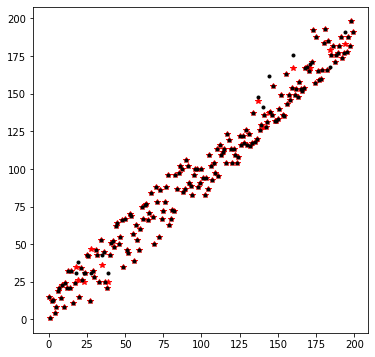

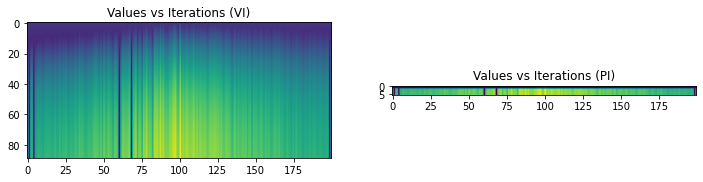

In [37]:
# A lot of randomness in move selection
import time
world = AdjacencyWorld(200, band_size=20, edge_rate=0.1, random_move_chance=0.5)

stime = time.time()
all_values_vi = value_iteration(world, 100)
policy_vi = compute_policy_from_values(world, all_values[-1])
print(f'Value Iteration Time: {time.time() - stime}')

stime = time.time()
policy_pi, all_values_pi = policy_iteration(world, 100)
print(f'Policy Iteration Time: {time.time() - stime}')

plt.figure(figsize=(6, 6))
plt.plot(policy_vi, 'r*')
plt.plot(policy_pi, 'k.')

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(all_values_vi)
plt.title("Values vs Iterations (VI)")
plt.subplot(122)
plt.imshow(all_values_pi)
plt.title("Values vs Iterations (PI)")

pv = evaluate_policy(world, policy_vi)
print(f"Value Iteration Avg. Value: {np.mean(pv)}")
pv = evaluate_policy(world, policy_pi)
print(f"Policy Iteration Avg. Value: {np.mean(pv)}")

None

## P4.4: Q Learning [8 points]

Finally, you'll be implementing Q Learning. Instructions here are a bit sparse, but I figure you probably know what you're doing by now!

**TASK** Implement Q Learning (use the lecture slides as a reference).

**CODE** Include your Q Learning implementation in your writeup

**PLOTS** Run the evaluation code below. Include all plots and the results (the average value for each value of the learning rate) in your writeup. You should notice the performance peaks around a learning rate of 0.02.

**QUESTION** (1-3 sentences) The rate of convergence for Q learning is significantly slower than that of Value Iteration. What information does Value Iteration have access to (and indeed makes use of) that makes it converge faster?

**QUESTION** (3-5 sentences) When the learning rate is very low, the performance is not particularly good. From looking at the plots of the total reward over time, what is likely the cause? How would you fix this issue (without changing the learning rate)?

**QUESTION** (2-4 sentences) When the learning is too high, the performance is also not very good. Why does this happen?

In [38]:
# Starter Code: Q Learning

def Q_learning(env, num_iterations, num_steps=30, gamma=0.98,
               learning_rate=0.005, epsilon=0.1, seed=695):
    random.seed(seed)
    np.random.seed(seed)
    Q_s_a = np.zeros((len(env.states), len(env.states)))
    total_rewards = []
    # Iterate
    for ii in range(num_iterations):
        # Rollout
        total_reward = 0
        state = env.get_random_state()
        for ii in range(num_steps):
            # Take an action and get the reward
            actions = env.get_actions_for_state(state)
            if random.random() > epsilon:
                action_ind = np.argmax(Q_s_a[state, actions])
                action = actions[action_ind]
            else:
                action = random.choice(actions)
            r, new_state = env.execute_action(state, action)
            new_actions = env.get_actions_for_state(new_state)
            # Update Q
            Q_s_a[state, action] += learning_rate * (r + (gamma * np.max(Q_s_a[new_state, new_actions])) - Q_s_a[state, action])
            
            
            # Update reward and state
            total_reward += r
            state = new_state

        total_rewards.append(total_reward)

    policy = np.zeros(len(env.states))
    for state in env.states:
        actions = env.get_actions_for_state(state)
        action_ind = np.argmax(Q_s_a[state, actions])
        policy[state] = actions[action_ind]
    return list(policy.astype(int)), total_rewards

Policy Iteration Avg. Value: 279.70336619955066
Q Learning Avg. Value (0.001): 159.43787211551074
Q Learning Avg. Value (0.005): 245.57602303534043
Q Learning Avg. Value (0.02): 260.4733408376938
Q Learning Avg. Value (0.1): 229.03788753554144
Q Learning Avg. Value (1.0): -45.77301680451045


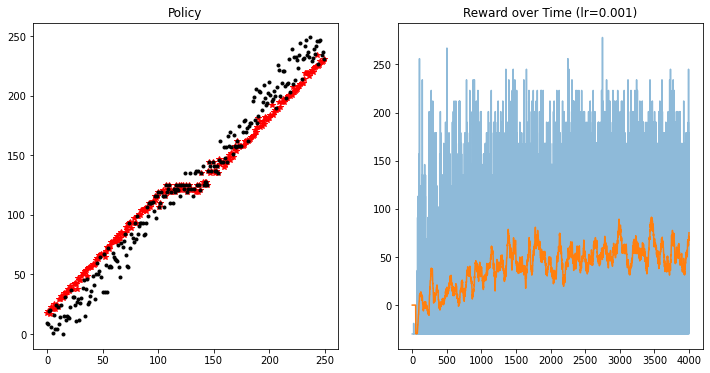

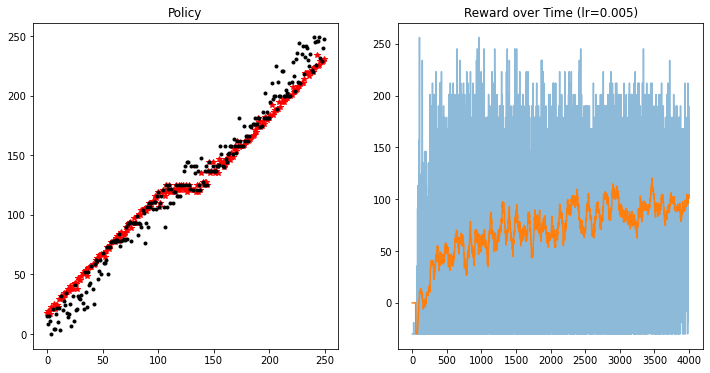

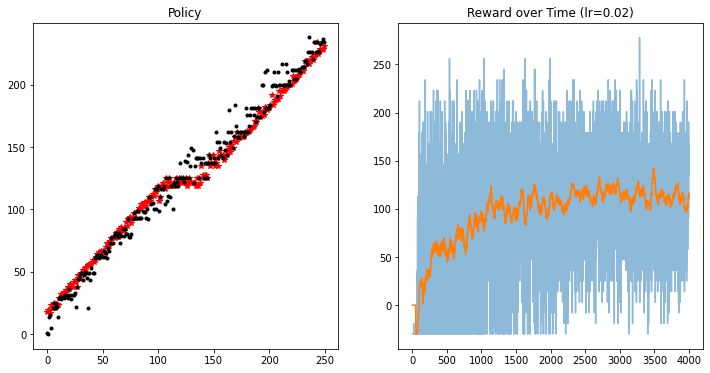

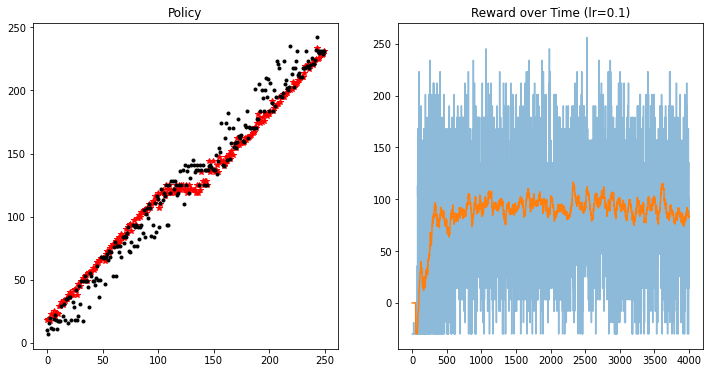

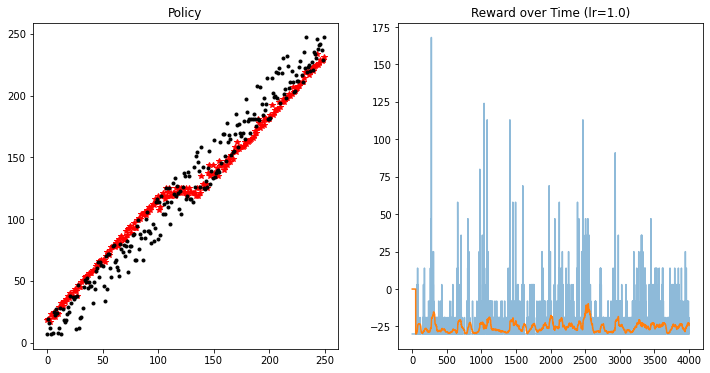

In [39]:
# Evaluation code

world = AdjacencyWorld(250, band_size=20, edge_rate=0.4, random_move_chance=0.3)

def smooth_data(data, window_width=50):
    summed_data = np.cumsum(data)
    sm_data = (summed_data[window_width:] - summed_data[:-window_width]) / window_width
    return np.concatenate([np.zeros(window_width), sm_data])


def evaluate_q_learning(learning_rate):
    policy_ql, rewards = Q_learning(world, num_iterations=4000,
                                    learning_rate=learning_rate)
    pv = evaluate_policy(world, policy_ql)
    print(f"Q Learning Avg. Value ({learning_rate}): {np.mean(pv)}")

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(policy_pi, 'r*')
    plt.plot(policy_ql, 'k.')
    plt.title('Policy')

    plt.subplot(122)
    plt.plot(rewards, alpha=0.5)
    plt.plot(smooth_data(rewards))
    plt.title(f'Reward over Time (lr={learning_rate})')


policy_pi, _ = policy_iteration(world, num_iterations=100, gamma=0.98)
pv = evaluate_policy(world, policy_pi)
print(f"Policy Iteration Avg. Value: {np.mean(pv)}")

evaluate_q_learning(learning_rate=0.001)
evaluate_q_learning(learning_rate=0.005)
evaluate_q_learning(learning_rate=0.02)
evaluate_q_learning(learning_rate=0.10)
evaluate_q_learning(learning_rate=1.00)
None